<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Ballistic-Monte-Carlo" data-toc-modified-id="Ballistic-Monte-Carlo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ballistic Monte Carlo</a></span></li><li><span><a href="#Features-to-be-implemented" data-toc-modified-id="Features-to-be-implemented-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Features to be implemented</a></span></li><li><span><a href="#Generate-frame" data-toc-modified-id="Generate-frame-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate frame</a></span></li><li><span><a href="#Bandstructure" data-toc-modified-id="Bandstructure-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bandstructure</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Serial" data-toc-modified-id="Serial-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Serial</a></span></li><li><span><a href="#Parallel" data-toc-modified-id="Parallel-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Parallel</a></span></li></ul></li><li><span><a href="#The-returned-data" data-toc-modified-id="The-returned-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>The returned data</a></span><ul class="toc-item"><li><span><a href="#edge_to_count" data-toc-modified-id="edge_to_count-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>edge_to_count</a></span></li><li><span><a href="#Trajectories" data-toc-modified-id="Trajectories-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Trajectories</a></span></li></ul></li></ul></div>

# Init

In [1]:
import time
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import geo.caustic_frame as caustic_frame
import monte_carlo_simulation as mcs
from bandstructure.delafossite_bandstructure import delafossite

# Set default plotting parameters
plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

# Ballistic Monte Carlo

In ultra-clean 2D materials, transport is ballistic over large length scales at sufficiently low temperatures. This simulation platform aims to  semi-classically model ballistic transport for a generic Fermi surface in a given 2D geometry. By modeling the ballistic trajectories in field, on can gain an effective map of the current density within the device. Additionally, by monitoring the interactions of the charge carriers with the edges of the device, one can gain qaulitative predictions for the field-dependence of the voltage at a given ohmic contact.

# Features to be implemented

- Specular reflection


- Ability to selectively save trajectory information


- Post processing of data
    - Capability to calculate flux for a given line
    - Generating color maps of electron density

# Generate frame

The Frame class represents the geometry we would like to simulate. To generate a frame load in a dxf file.

When generating a caustic frame, all layers are collapsed down onto layer 0 to generate a single polygon. Layer 0 will function as a regular edge of the given material while higher layers will function as ohmic contacts. Any line segment of layer 0 that is totally encompased in a higher layer polygon is now labeled by the higher layer. A line segment of layer 0 that  intersects with a higher layer polygon is divided to a portion inside and outside of the higher layer polygon. The portion outside remains labeled by layer 0 while the portion inside aquires the layer of the polygon. 

Each layer functions as a single ohmic contact (or multiple contacts that are shorted together in the case of disjoin polygons). An injecting contact (layer 1) and a grounded contact (layer 2) are required. All highe layers will be considered as floating contacts.

See the figures below for an example dxf which is then collapsed down into a Frame.


Required layers: 
- 1: Body of device, must be a single polygon
- 2: Injecting contact(s)
- 3: Grounded contacts(s)

Optional layers:
- 3-n: floating contacts, grouped by layer

[3, 3, 1, 2, 2, 2, 1, 3]
3
3
2
2
2
3


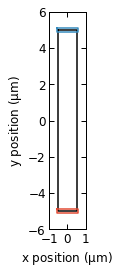

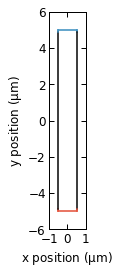

In [2]:
frame = caustic_frame.Frame('geo/bar.dxf')

# Original DXF
fig, ax = plt.subplots()
colors = ['k', 'C0', 'C1']
for i, layer in enumerate(frame.ps.keys()):
    x,y = zip(*frame.ps[layer][0])
    plt.plot(x,y, color=colors[i])
plt.xlabel(r'x position ($\mathrm{\mu m}$)')
plt.ylabel(r'y position ($\mathrm{\mu m}$)')
plt.xlim(-1, 1)
plt.ylim(-6, 6)
ax.set_aspect('equal')

# Caustic frame
frame.gen_fig();
plt.xlabel(r'x position ($\mathrm{\mu m}$)')
plt.ylabel(r'y position ($\mathrm{\mu m}$)')
plt.xlim(-1, 1)
plt.ylim(-6, 6)
ax = plt.gca()
ax.set_aspect('equal')

The frame consists of a collection of edges (a helper class where we easily store information about a given edge, such as its vertices, layer, and injection probability distribution). We will come back to this once we load in the bandstructure

In [3]:
frame.ps

{'1': [[(-0.5, 5.0), (0.5, 5.0), (0.5, -5.0), (-0.5, -5.0), (-0.5, 5.0)]],
 '2': [[(-0.6, -4.9), (0.6, -4.9), (0.6, -5.1), (-0.6, -5.1), (-0.6, -4.9)]],
 '3': [[(-0.6, 5.1), (0.6, 5.1), (0.6, 4.9), (-0.6, 4.9), (-0.6, 5.1)]]}

In [4]:
frame.edges

[((-0.5, 5.0), (0.5, 5.0), 3),
 ((0.5, 5.0), (0.5, 4.9), 3),
 ((0.5, 4.9), (0.5, -4.9), 1),
 ((0.5, -4.9), (0.5, -5.0), 2),
 ((0.5, -5.0), (-0.5, -5.0), 2),
 ((-0.5, -5.0), (-0.5, -4.9), 2),
 ((-0.5, -4.9), (-0.5, 4.9), 1),
 ((-0.5, 4.9), (-0.5, 5.0), 3)]

# Bandstructure

Next, we call the delafossite function, which returns a list of of arrays [kx, ky] to represent the Fermi surface. PdCoO2 experimentally has been show to have a nearly constant Fermi velocity across its Fermi surface, so I interpolate the points on the Fermi surface to be separated by constant arc length. If this is not the case for your material, the points should be separated by a distance proportional to the local Fermi velocity.

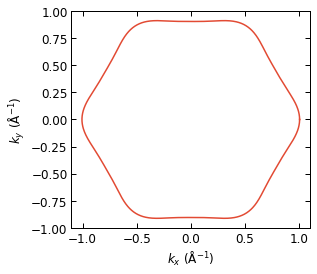

In [5]:
k = delafossite()

fig, ax = plt.subplots()
plt.plot(k[0], k[1])
plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
ax.set_aspect('equal')

# Simulation

Our simulation is run through Simulation, which takes in our Frame and list of wavevectors. It also takes in: 

- phi: angle of rotation of device relative to crystal axis
- field: Magnetic field to simulate

Based on the Fermi surface and given field, the real space trajectories of the charge carriers will be calculated. It turns out that this will be a 90 degree rotation of the Fermi surface scaled by a factor of 1/field. The handedness of these real space trajectories depends on the sign of the field.

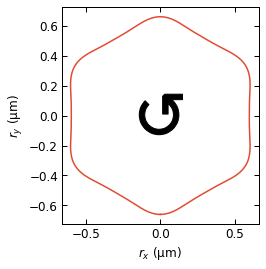

In [6]:
phi = 0
field = 10
sim = mcs.Simulation(frame, k, phi, field)

fig, ax = plt.subplots()
if np.sign(field) == 1:
    plt.plot([-0.02], [0], marker=r'$\circlearrowleft$', ms=50, color='k')
else:
    plt.plot([-0.02], [0], marker=r'$\circlearrowright$', ms=50, color='k')
plt.plot(sim._bandstructure.r[0], sim._bandstructure.r[1])
plt.xlabel(r'$r_x\ (\mathrm{\mu m})$')
plt.ylabel(r'$r_y\ (\mathrm{\mu m})$')
ax.set_aspect('equal')

Simulation stores information on how electrons should be injected into the device. However, the probability distribution for which state electrons should be injected into depends on the normal direction of the edge (where we take the normal to point into the device). 


We can plot the probability distribution for a given edge in both reciprocal and real space (blue [red] corresponds to zero [high] probability of injection). The drawn black line corresponds to the normal vector for this edge. We can see that there is a non-zero probability only for injection into states where the charge carrier will propigate in the direction of the normal.

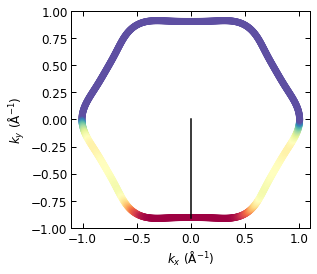

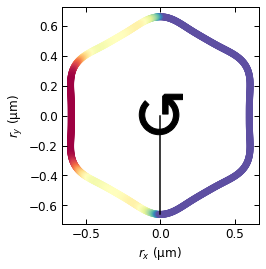

In [7]:
cmap = plt.get_cmap('Spectral_r')
    
edge = sim._frame.edges[0]
max_p = np.max(edge.in_prob)
colors = np.array([cmap(p/max_p) for p in edge.in_prob])
colors = np.append(colors, [colors[0]], axis=0)

# Fermi surface
fig, ax = plt.subplots()
plt.plot((0, (np.max(sim._bandstructure.k[0]*np.cos(edge.normal_angle)))*np.cos(edge.normal_angle)), 
         (0, (np.max(sim._bandstructure.k[1]*np.sin(edge.normal_angle)))*np.sin(edge.normal_angle)),'k')
plt.scatter(sim._bandstructure.k[0], sim._bandstructure.k[1],c=colors)
plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
ax.set_aspect('equal')

# Real space trajectory
fig, ax = plt.subplots()
if np.sign(field) == 1:
    plt.plot([-0.02], [0], marker=r'$\circlearrowleft$', ms=50, color='k')
else:
    plt.plot([-0.02], [0], marker=r'$\circlearrowright$', ms=50, color='k')
plt.plot((0, (np.max(sim._bandstructure.r[0]*np.cos(edge.normal_angle)))*np.cos(edge.normal_angle)), 
         (0, (np.max(sim._bandstructure.r[1]*np.sin(edge.normal_angle)))*np.sin(edge.normal_angle)),'k')
plt.scatter(sim._bandstructure.r[0], sim._bandstructure.r[1],c=colors)
plt.xlabel(r'$r_x\ (\mathrm{\mu m})$')
plt.ylabel(r'$r_y\ (\mathrm{\mu m})$')
ax.set_aspect('equal')

## Serial

We are now ready to run the simulation. The simulation can be run in serial. Here we explicitly set the seed before each run of the simulation so that we can repeate the results.

In [8]:
k = delafossite()
bar_frame = caustic_frame.Frame('geo/bar.dxf')
fields = np.linspace(10, 15, 8)
phi = 0
n_inject = 10

start = time.time()
for field in fields:
    np.random.seed(42)
    bar_sim = mcs.Simulation(bar_frame, k, phi, field)
    edge_to_collisions, trajectories = bar_sim.run_simulation(n_inject)
    print(f'{field:.1f} T: {list(map(len, trajectories))}')
print(f'Completed in {time.time() - start:.1f} s')

[3, 3, 1, 2, 2, 2, 1, 3]


/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:341: RuntimeWarning: divide by zero encountered in true_divide
  (x01*self._frame.y23 - y01*self._frame.x23)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:342: RuntimeWarning: divide by zero encountered in true_divide
  us = -(x01*y02 - y01*x02) / (x01*self._frame.y23 - y01*self._frame.x23)


10.0 T: [7478, 1718, 39627, 7646, 9110, 11087, 14151, 67, 11006, 1456]
10.7 T: [12872, 1951, 6688, 13891, 4408, 4077, 32343, 9722, 6827, 8530]
11.4 T: [6585, 399, 6676, 10257, 9937, 3454, 12843, 542, 17338, 1394]
12.1 T: [7281, 7235, 2469, 4750, 11046, 5134, 8363, 4198, 1851, 10677]
12.9 T: [7526, 7711, 13721, 9041, 11508, 3715, 4490, 6848, 5711, 2251]
13.6 T: [7869, 4603, 9594, 4467, 9257, 6619, 1404, 3294, 4856, 13556]
14.3 T: [8371, 11381, 4274, 11638, 13233, 10253, 10105, 9326, 13237, 13511]
15.0 T: [8637, 11797, 4359, 12338, 7184, 11068, 4663, 12788, 4647, 1980]
Completed in 17.3 s


## Parallel

We can also run this in parallel! However, we need to be careful with seeding. If we set maxtasksperchild=1 then each process in our multiprocessing pool will begin with the same seed. This is much quicker!

In [9]:
start = time.time()
results = []
np.random.seed(42)
with multiprocessing.Pool(maxtasksperchild=1) as p:
    for field in fields:
        bar_sim = mcs.Simulation(bar_frame, k, 0, field)
        results.append(p.apply_async(bar_sim.run_simulation, [n_inject]))
    p.close()
    p.join()
for r, field in zip(results, fields):
    print(f'{field:.1f} T: {list(map(len, r.get()[1]))}')
print(f'Completed in {time.time() - start:.1f} s')

10.0 T: [7478, 1718, 39627, 7646, 9110, 11087, 14151, 67, 11006, 1456]
10.7 T: [12872, 1951, 6688, 13891, 4408, 4077, 32343, 9722, 6827, 8530]
11.4 T: [6585, 399, 6676, 10257, 9937, 3454, 12843, 542, 17338, 1394]
12.1 T: [7281, 7235, 2469, 4750, 11046, 5134, 8363, 4198, 1851, 10677]
12.9 T: [7526, 7711, 13721, 9041, 11508, 3715, 4490, 6848, 5711, 2251]
13.6 T: [7869, 4603, 9594, 4467, 9257, 6619, 1404, 3294, 4856, 13556]
14.3 T: [8371, 11381, 4274, 11638, 13233, 10253, 10105, 9326, 13237, 13511]
15.0 T: [8637, 11797, 4359, 12338, 7184, 11068, 4663, 12788, 4647, 1980]
Completed in 7.4 s


# The returned data

## edge_to_count

The main data set is the number of collisions with each edge of the device. This can be used to map to the voltage at a non-grounded contact.

The data set is returned as a dictionary which maps between the edges and the number of collisions.

In [10]:
for r, field in zip(results, fields):
    print(f'{field:.1f} T: {list(r.get()[0].values())}')

10.0 T: [8, 1, 104, 1, 23, 3, 145, 1]
10.7 T: [10, 0, 88, 0, 14, 1, 141, 0]
11.4 T: [9, 0, 55, 1, 7, 0, 90, 1]
12.1 T: [9, 0, 31, 2, 4, 1, 86, 1]
12.9 T: [8, 0, 32, 0, 13, 1, 104, 2]
13.6 T: [9, 0, 24, 0, 5, 0, 103, 1]
14.3 T: [10, 0, 65, 1, 19, 0, 133, 0]
15.0 T: [9, 0, 39, 1, 4, 0, 112, 1]


We will group the counts by layer

In [11]:
ohmstats = mcs.calc_ohmstats(fields, results)
ohmstats

{3: array([10., 10., 10., 10., 10., 10., 10., 10.]),
 1: array([249., 229., 145., 117., 136., 127., 198., 151.]),
 2: array([27., 15.,  8.,  7., 14.,  5., 20.,  5.])}

The frame contains the lengths of each ohmic (layer in the dxf)

In [12]:
frame.ohmic_lengths

{3: 1.1999999999999993, 1: 19.6, 2: 1.1999999999999993}

Now plot the results vs. field. We don't plot the grounded contact or the regular edges

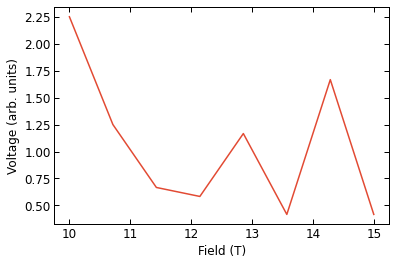

In [14]:
fig = plt.figure()
for layer in ohmstats.keys():
    if layer != 1 and layer != 3:
        plt.plot(fields, ohmstats[layer]/(n_inject*frame.ohmic_lengths[layer]))
plt.xlabel(r'Field (T)')
plt.ylabel(r'Voltage (arb. units)')
plt.show()

## Trajectories

The simulation also can return information on the paths the charge carriers took.

3
3
2
2
2
3
3
3
2
2
2
3
3
3
2
2
2
3
3
3
2
2
2
3
3
3
2
2
2
3
3
3
2
2
2
3
3
3
2
2
2
3
3
3
2
2
2
3


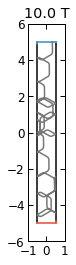

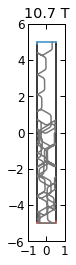

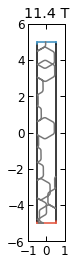

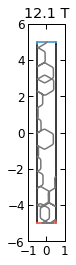

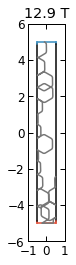

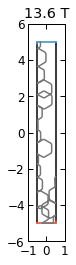

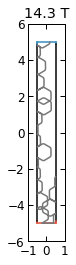

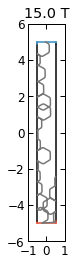

In [15]:
for i,result in enumerate(results):
    _, trajectories = result.get()
    trajectory = trajectories[0]
    fig = bar_frame.gen_fig()
    ns, xs, ys, state, edge = zip(*trajectory)
    plt.plot(xs,ys, 'C3-')
    f = fields[i]
    plt.title(str(round(fields[i],1))+' T')
    plt.xlim(-1, 1)
    plt.ylim(-6, 6)
    ax = plt.gca()
    ax.set_aspect('equal')